# Charger le dataset

In [304]:
import pandas as pd
import numpy as np
import sys
import sklearn
from time import time


col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate", "attack"]

df = pd.read_csv('https://raw.githubusercontent.com/Bilou75019/KDD-project/master/KDD_files/KDDTrain%2B.csv', delimiter=',')
df_test = pd.read_csv('https://raw.githubusercontent.com/Bilou75019/KDD-project/master/KDD_files/KDDTest%2B.csv', delimiter=',')

#delete 43th column
df = df.iloc[:,:-1]
df_test = df_test.iloc[:,:-1]


#trie les attaques et les packets bénins
def labeling(x):
    if x == 'normal':
        return 0
    else:
        return 1

# on rajoute une colonne label selon le resultat de labeling
label = df['attack']
class_label = label.map(labeling)
df['label'] = class_label

# test data  
label = df_test['attack']
class_label = label.map(labeling)
df_test['label'] = class_label

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,0


#

# Séparer données nominal, numériques et binaires

In [305]:
col_sep_names = np.array(col_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_sep_names[nominal_idx].tolist()
binary_cols = col_sep_names[binary_idx].tolist()
numeric_cols = col_sep_names[numeric_idx].tolist()

print(nominal_cols)
print(binary_cols)
print(numeric_cols)


['protocol_type', 'service', 'flag']
['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


# Créer l'ensemble d'entrainement et de test

In [169]:
import matplotlib.pyplot as plt
#df.hist(bins=50, figsize=(50,50), column="num_shells", range=[0,1])
#df.hist(bins=50, figsize=(50,50), column="src_bytes", range=[0,10000])
#df.hist(bins=50, figsize=(50,50), column="dst_bytes", range=[0,10000])
#df.hist(bins=50, figsize=(50,50), column="duration", range=[0,10000])
#df.hist(bins=50, figsize=(50,50), column="diff_srv_rate", range=[0,1.25])

plt.show()

# Sélection proportionnelle des samples selon les meilleurs features

<AxesSubplot:>

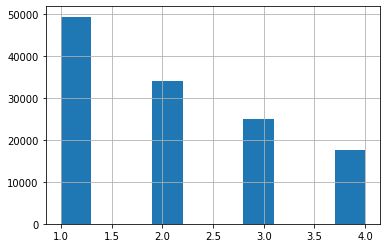

In [306]:
df["to_prop"] = pd.cut(df["src_bytes"],
                           bins=[-1, 0, 220, 350, np.inf],
                               labels=[1, 2, 3, 4])
df["to_prop"].hist()


<AxesSubplot:>

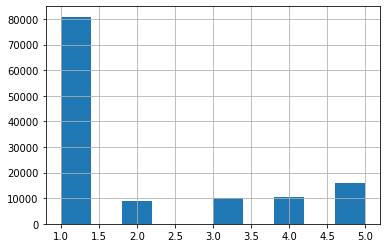

In [177]:
df["to_prop"] = pd.cut(df["dst_bytes"],
                           bins=[-1, 200, 350, 1000, 2500, np.inf],
                               labels=[1, 2, 3, 4, 5])
df["to_prop"].hist()

<AxesSubplot:>

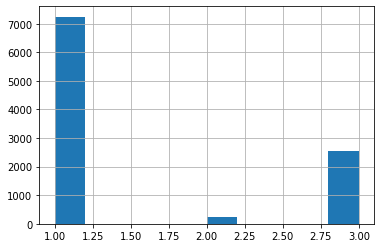

In [179]:
df["to_prop"] = pd.cut(df["duration"],
                               bins=[-1, 1000, 2000, np.inf],
                               labels=[1, 2, 3])
df["to_prop"].hist()


<AxesSubplot:>

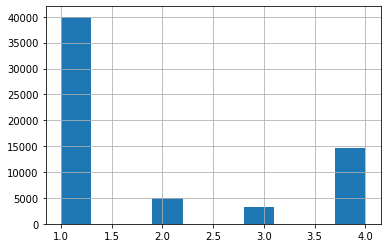

In [152]:
df["to_prop"] = pd.cut(df["dst_host_same_src_port_rate"],
                               bins=[-1, 0.2, 0.4, 0.6, np.inf],
                               labels=[1, 2, 3, 4])
df["to_prop"].hist()

<AxesSubplot:>

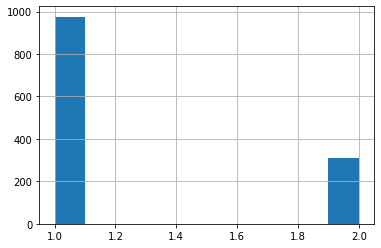

In [153]:
df["to_prop"] = pd.cut(df["num_compromised"],
                               bins=[-1, 1, np.inf],
                               labels=[1, 2])
df["to_prop"].hist()

<AxesSubplot:>

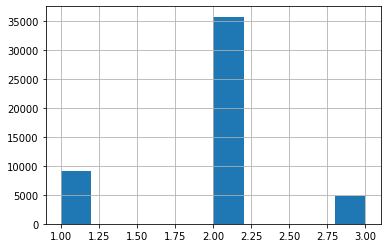

In [163]:
df["to_prop"] = pd.cut(df["diff_srv_rate"],
                               bins=[-1, 0.05, 0.5, 1, np.inf],
                               labels=[1, 2, 3, 4])
df["to_prop"].hist()

In [307]:
#we introduce these new catagories in our test and train training
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["to_prop"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

strat_test_set["to_prop"].value_counts() / len(strat_test_set)





1    0.392062
2    0.269736
3    0.198730
4    0.139472
Name: to_prop, dtype: float64

# Extraction des labels

In [308]:
#on enleve la colonne to_prop créer sur train et test_set
for set_ in (strat_train_set, strat_test_set): 
     set_.drop("to_prop", axis=1, inplace=True)


#on extrait les labels
train_set = strat_train_set.drop("label", axis=1)
test_set = strat_test_set.drop("label", axis=1)
train_labels =  strat_train_set["label"].copy()
test_labels =  strat_test_set["label"].copy()

print(train_labels)
print("------------------------")
print(test_labels)


50986     0
121172    0
69203     1
77971     1
44883     0
         ..
62688     0
112577    1
34297     0
4646      1
19068     0
Name: label, Length: 100778, dtype: int64
------------------------
97689     0
119588    1
22805     0
90305     0
1254      1
         ..
19297     0
94569     0
72166     0
10941     1
6552      1
Name: label, Length: 25195, dtype: int64


# Distribution stat des valeurs continues

In [309]:
print(train_set['duration'].describe())
print(train_set['hot'].describe())
train_set['src_bytes'].describe()
# valeurs non normalisés


count    100778.00000
mean        292.64916
std        2638.55082
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64
count    100778.000000
mean          0.205352
std           2.158773
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          77.000000
Name: hot, dtype: float64


count    1.007780e+05
mean     4.816280e+04
std      6.188757e+06
min      0.000000e+00
25%      0.000000e+00
50%      4.400000e+01
75%      2.760000e+02
max      1.379964e+09
Name: src_bytes, dtype: float64

# nettoyage du dataset

In [310]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

# traitement du jeu d'entrainement et de test

In [251]:
from sklearn.base import BaseEstimator, TransformerMixin


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
      
      return X

In [311]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])


#drop all cateogrical values to apply the fit transform
train_set_num = train_set.drop(['service','protocol_type','flag','attack'], axis=1)
train_set_num_tr = num_pipeline.fit_transform(train_set_num)

print(train_set_num_tr)



[[-1.10913388e-01 -7.75762210e-03 -3.22220912e-04 ... -6.25442255e-01
  -3.87531026e-01 -3.76490125e-01]
 [-1.10913388e-01 -7.74873497e-03 -5.11648939e-03 ... -6.25442255e-01
  -3.87531026e-01 -3.76490125e-01]
 [-1.10913388e-01 -7.78234447e-03 -5.35515739e-03 ...  1.61733374e+00
  -3.87531026e-01 -3.76490125e-01]
 ...
 [-1.10913388e-01 -7.74469536e-03 -5.21369155e-03 ... -6.25442255e-01
  -3.87531026e-01 -3.76490125e-01]
 [-1.10913388e-01 -7.78234447e-03 -5.35515739e-03 ...  1.61733374e+00
  -3.87531026e-01 -3.76490125e-01]
 [-1.10913388e-01 -7.28838173e-03 -5.28153287e-03 ... -6.25442255e-01
  -3.87531026e-01 -3.76490125e-01]]


In [312]:
#get categorical values and apply ONE to them
categorical_features = train_set.select_dtypes(['object', 'bool', 'category']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

print(categorical_features)

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')


In [313]:
#get numeric features

numeric_features = train_set.select_dtypes(np.number).columns
print(numeric_features)

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')


In [314]:
# construct the full pipeline with ColumnTransformer which allows to standard scaled numeric data
# Construct ColumnTransformer object
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    verbose=True)

In [315]:
#construct the final train set with full pipeline
train_set_prepared = full_pipeline.fit_transform(train_set)
enc_cat_features = full_pipeline.named_transformers_['cat']['onehot'].get_feature_names()
feature_names = np.concatenate([numeric_features, enc_cat_features])
feature_names

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.9s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


c:\Users\Ilias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'x0_icmp',
       'x0_tcp', 'x0_udp', 'x1_IRC', 'x1_X11', 'x1_Z39_50', 'x1_aol',
       'x1_auth', 'x1_bgp', 'x1_courier', 'x1_csnet_ns', 'x1_ctf',
       'x1_daytime', 'x1_discard', 'x1_domain', 'x1_domain_u', 'x1_echo',
  

In [316]:
#construct final test set
test_set_prepared = full_pipeline.fit_transform(test_set)
print(test_set_prepared)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.3s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s
[[-0.10761961 -0.00796925  0.15243502 ...  0.          0.
   0.        ]
 [-0.10761961 -0.00805001 -0.04095892 ...  0.          0.
   0.        ]
 [-0.10761961 -0.00798389 -0.03821081 ...  0.          0.
   0.        ]
 ...
 [-0.10761961 -0.00799968 -0.00156941 ...  0.          0.
   0.        ]
 [-0.10761961 -0.00804979 -0.04095892 ...  0.          0.
   0.        ]
 [-0.10761961 -0.00804818 -0.04095892 ...  0.          0.
   0.        ]]


# Entrainement Logistic Regression

In [317]:
#regression log avec le jeu d'entraintement
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss="log", penalty="none")
lr.fit(train_set_prepared, train_labels)

#ensemble de test
lv = SGDClassifier(loss="log", penalty="none")
lv.fit(test_set_prepared, test_labels)


c:\Users\Ilias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\Ilias\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(loss='log', penalty='none')

In [318]:
from sklearn.metrics import mean_squared_error
train_predictions = lr.predict(train_set_prepared)
lin_mse = mean_squared_error(train_labels, train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #affiche les erreurs de prédiction sur le jeu d'entrainement

0.019418198248738004

# Test Regression L

In [319]:
final_predictions = lv.predict(test_set_prepared)
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)   
final_rmse #affiche les erreurs de prédiction sur le jeu de test

0.006300032917757993

# Entrainement KNN

In [345]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier for ensemble de train
k = 3
knn_train = KNeighborsClassifier(n_neighbors = k, n_jobs=-1)
# Fit the classifier to the data
knn_train.fit(train_set_prepared,train_labels)

# Create KNN classifier for ensemble de test
knn_test = KNeighborsClassifier(n_neighbors = k, n_jobs=-1)
# Fit the classifier to the data
knn_test.fit(test_set_prepared,test_labels)



KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [346]:
from sklearn.metrics import mean_squared_error
train_predictions = knn_train.predict(train_set_prepared)
lin_mse = mean_squared_error(train_labels, train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #erreur de pred sur le jeu d'entrainement / k = 3, err=0.022 soit 2.2%

0.0227153171182952

# test KNN

In [344]:
final_predictions = knn_test.predict(test_set_prepared)
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)   
final_rmse #affiche les erreurs de prédiction sur le jeu de test / k=3, err=0.037 best for test set soit 3.7% d'err

0.03780019750654796